In [69]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/Julia/tinympc-julia/quat_mpc_lqr/Project.toml`


In [70]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random; 
using Printf

In [71]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

In [167]:
#Quadrotor parameters
m = 0.035
ℓ = 0.046
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
g = 9.81
# thrustToTorque = 0.005964552
thrustToTorque = 0.0008
ℓ = 0.046/sqrt(2)
scale = 65535
kt = 2.245365e-6*scale # u is PWM in range [0...1]
km = kt*thrustToTorque #4.4733e-8

freq1 = 50
h = 1/freq1 #50 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4     # number of controls
nx = Nx̃
nu = Nu
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)
thist = Array(range(0,h*(Nt-1), step=h));

In [168]:
function quad_dynamics(x,u)
  r = x[1:3]
  q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
  v = x[8:10]
  ω = x[11:13]
  Q = qtoQ(q)
  
  ṙ = v
  q̇ = 0.5*L(q)*H*ω
  
  v̇ = [0; 0; -g] + (1/m)*Q*[zeros(2,4); kt*ones(1,4)]*u 

  ω̇ = J\(-hat(ω)*J*ω + [-ℓ*kt -ℓ*kt ℓ*kt ℓ*kt; -ℓ*kt ℓ*kt ℓ*kt -ℓ*kt; -km km -km km]*u)
  
  return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u,h)
  #RK4 integration with zero-order hold on u
  f1 = quad_dynamics(x, u)
  f2 = quad_dynamics(x + 0.5*h*f1, u)
  f3 = quad_dynamics(x + 0.5*h*f2, u)
  f4 = quad_dynamics(x + h*f3, u)
  xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
  xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
  return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [169]:
#Goal state
@show uhover = (m*g/kt/4)*ones(4)  # m = 30g and max thrust = 60g
rg = [0.0; 0; 0.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

uhover = (((m * g) / kt) / 4) * ones(4) = [0.5833333520642209, 0.5833333520642209, 0.5833333520642209, 0.5833333520642209]


In [170]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover,h),xg)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u,h),uhover);
Ã = Array(E(qg)'*A*E(qg))
B̃ = Array(E(qg)'*B);
function discrete_dynamics(params,x,u,k)
  Ã*x + B̃*u 
end

discrete_dynamics (generic function with 1 method)

In [171]:
# #Linearize dynamics about hover
# A1 = ForwardDiff.jacobian(x->quad_dynamics(x,uhover),xg)
# B1 = ForwardDiff.jacobian(u->quad_dynamics(xg,u),uhover);
# Ã1 = Array(E(qg)'*A1*E(qg))
# B̃1 = Array(E(qg)'*B1);

In [172]:
# Adaptive step in MPC horizon: use normal dt and model in the first specified 
# `adaptive_step` steps and after that use the stretch mode (larger dt and model)
freq2 = 10
h = 1/freq2 #25 Hz stretch interval dynamics
#Linearize dynamics about hover
As = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover,h),xg)
Bs = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u,h),uhover);
Ãs = Array(E(qg)'*As*E(qg))
B̃s = Array(E(qg)'*Bs);
function discrete_dynamics_stretch(params,x,u,k)
  Ãs*x + B̃s*u
end


discrete_dynamics_stretch (generic function with 1 method)

In [173]:
h = 1/freq1 #50 Hz normal dynamics
step_ratio = Int(freq1/freq2)
# display(Ãs)
# display(Ã)

5

In [284]:
# IHLQR terminal cost
P = [zeros(nx,nx) for i = 1:200]   # cost to go quadratic term
p = [zeros(nx) for i = 1:200]      # cost to go linear term
d = [zeros(nu) for i = 1:200-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:200-1] # feedback gain

# Cost weights
# Saved
# max_dev_x = [0.1; 0.1; 0.1;  0.5; 0.5; 0.05;  0.5; 0.5; 0.5;  0.5; 0.5; 0.1]
# max_dev_u = [0.5; 0.5; 0.5; 0.5]/10
max_dev_x = [0.08; 0.08; 0.05;  0.6; 0.6; 0.05;  0.5; 0.5; 0.5;  0.5; 0.5; 0.2]
max_dev_u = [0.5; 0.5; 0.5; 0.5]/10
Q = diagm(1 ./(max_dev_x.^2))
R = diagm(1 ./(max_dev_u.^2))

# Q = Array(Diagonal([10; 10; 10; 1; 1; 1; 1; 1; 1; 1; 1; 1.]));
# R = Array(1*I(Nu));
Qf = 1*Q

# PENALTY - important!!
ρ = 250.0
R̃ = R + ρ*I  

display(Q)
display(R̃)

# Precompute
cache = (
    Kinf = zeros(nu,nx),
    Pinf = zeros(nx,nx),
    Kinf2 = zeros(nu,nx),
    Pinf2 = zeros(nx,nx),
    Quu_inv = zeros(nu,nu),
    Quu_inv2 = zeros(nu,nu),
    AmBKt = zeros(nx,nx), 
    AmBKt2 = zeros(nx,nx), #(Ã - B̃*K[1])',
    coeff_d2p = zeros(nx,nu), 
    coeff_d2p2 = zeros(nx,nu), 
)

P[200] .= Q
for k = (200-1):-1:1
    K[k] .= (R̃ + B̃s'*P[k+1]*B̃s)\(B̃s'*P[k+1]*Ãs)
    P[k] .= Q + Ãs'*P[k+1]*(Ãs - B̃s*K[k])
end
cache.Kinf2 .= K[1]  # correct, tested with dlqr
cache.Pinf2 .= P[1]
cache.AmBKt2 .= (Ãs - B̃s*K[1])'
for k = (200-1):-1:1
    K[k] .= (R̃ + B̃'*P[k+1]*B̃)\(B̃'*P[k+1]*Ã)
    P[k] .= Q + Ã'*P[k+1]*(Ã - B̃*K[k])
end
cache.Kinf .= K[1]
cache.Pinf .= P[1]
cache.AmBKt .= (Ã - B̃*K[1])'

cache.Quu_inv .= (R̃ + B̃'*cache.Pinf*B̃)\I
display(cond(cache.Quu_inv))
cache.Quu_inv2 .= (R̃ + B̃s'*cache.Pinf2*B̃s)\I

cache.coeff_d2p .= cache.Kinf'*R̃ - cache.AmBKt*cache.Pinf*B̃
cache.coeff_d2p2 .= cache.Kinf2'*R̃ - cache.AmBKt2*cache.Pinf2*B̃s;

12×12 Matrix{Float64}:
 156.25    0.0     0.0  0.0      0.0      …  0.0  0.0  0.0  0.0  0.0   0.0
   0.0   156.25    0.0  0.0      0.0         0.0  0.0  0.0  0.0  0.0   0.0
   0.0     0.0   400.0  0.0      0.0         0.0  0.0  0.0  0.0  0.0   0.0
   0.0     0.0     0.0  2.77778  0.0         0.0  0.0  0.0  0.0  0.0   0.0
   0.0     0.0     0.0  0.0      2.77778     0.0  0.0  0.0  0.0  0.0   0.0
   0.0     0.0     0.0  0.0      0.0      …  0.0  0.0  0.0  0.0  0.0   0.0
   0.0     0.0     0.0  0.0      0.0         4.0  0.0  0.0  0.0  0.0   0.0
   0.0     0.0     0.0  0.0      0.0         0.0  4.0  0.0  0.0  0.0   0.0
   0.0     0.0     0.0  0.0      0.0         0.0  0.0  4.0  0.0  0.0   0.0
   0.0     0.0     0.0  0.0      0.0         0.0  0.0  0.0  4.0  0.0   0.0
   0.0     0.0     0.0  0.0      0.0      …  0.0  0.0  0.0  0.0  4.0   0.0
   0.0     0.0     0.0  0.0      0.0         0.0  0.0  0.0  0.0  0.0  25.0

4×4 Matrix{Float64}:
 650.0    0.0    0.0    0.0
   0.0  650.0    0.0    0.0
   0.0    0.0  650.0    0.0
   0.0    0.0    0.0  650.0

2.790974121646514

In [285]:
display(cache.Kinf)
# C Language for LQR2 alone
@printf("FOR C:\n");
str = "static float K[NU][NXt] = {\n"
for i = 1:4
  str = str * "  {"
  for j = 1:12
    # if abs(K[i, j]) < 1e-6
    #   K[i, j] = 0.0
    # end
    this_str = @sprintf("%.6f", cache.Kinf[i, j])

    str = str * this_str * "f"
    if j < 12
      str = str * ","
    end
  end
  str = str * "},\n"
end
str = str * "};"
@printf("%s",str)

4×12 Matrix{Float64}:
 -0.14901    0.148895  0.378017  …  -0.0354364  -0.0421643  -0.181182
  0.143854   0.142199  0.378017     -0.0248133   0.0404852   0.181068
  0.145451  -0.147481  0.378017      0.0265055   0.0198322  -0.18077
 -0.140296  -0.143614  0.378017      0.0337441  -0.0181531   0.180884

FOR C:
static float K[NU][NXt] = {
  {-0.149010f,0.148895f,0.378017f,-0.460445f,-0.484674f,-0.378801f,-0.087547f,0.086307f,0.215372f,-0.035436f,-0.042164f,-0.181182f},
  {0.143854f,0.142199f,0.378017f,-0.406518f,0.464162f,0.379961f,0.084132f,0.080710f,0.215372f,-0.024813f,0.040485f,0.181068f},
  {0.145451f,-0.147481f,0.378017f,0.427294f,0.401721f,-0.382698f,0.082235f,-0.084188f,0.215372f,0.026506f,0.019832f,-0.180770f},
  {-0.140296f,-0.143614f,0.378017f,0.439670f,-0.381209f,0.381537f,-0.078820f,-0.082829f,0.215372f,0.033744f,-0.018153f,0.180884f},
};

In [286]:
#Feedback tracking controller
include("tinyMPC-ADMM-dt.jl")
N = 3
dt = 1/freq1
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)


#Create trajectory to follow
Xref = [[zeros(3); 1; zeros(9)] for i = 1:Nt]
Δx̃ref = [zeros(nx) for i = 1:Nt]
ΔUref = [zeros(nu) for i = 1:Nt-1]

## Hovering
Xref = [xg for i = 1:Nt]

## Number-eight
# Xref = [[1*cos(t)*sin(t);1*cos(t);0.5;1;zeros(9)] for t = range(-pi/2, 3*pi/2, length = Nt)]  

## Triangle
# p0 = [0; 0; 1.0]; p1 = [3; 4; 1.]; p2 = [0; 8; 1.]; p3 = [0; -2; 1.0]
# range1 = collect(LinRange(p0, p1, round(Int,(Nt)/3)))
# range2 = collect(LinRange(p1, p2, round(Int,(Nt)/3)))
# range3 = collect(LinRange(p2, p3, round(Int,(Nt)/3)+1))
# range123 = [range1; range2; range3]
# for k = 1:Nt
#     Xref[k][1:3] .= range123[k]
# end

## Square
# p0 = [0; 0; 0.5]; p1 = [2; 0; 0.5]; p2 = [2; 2; 0.5]; p3 = [0; 2; 0.5]
# range1 = collect(LinRange(p0, p1, round(Int,(Nt)/4)))
# range2 = collect(LinRange(p1, p2, round(Int,(Nt)/4)))
# range3 = collect(LinRange(p2, p3, round(Int,(Nt)/4)))
# range4 = collect(LinRange(p3, p0, round(Int,(Nt)/4)+1))
# range1234 = [range1; range2; range3; range4]
# for k = 1:Nt
#     Xref[k][1:3] .= range1234[k]
# end

# Velocity reference: speeds up the tracking but less smooth
for i = 1:Nt-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt/1.0
end
for k = 1:Nt
    x = Xref[k]
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)   
    Δx̃ref[k] .= [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
end


u_min = -uhover #-0.5*ones(nu)
u_max =  1 .- uhover #0.5*ones(nu)
u_max[1] = u_max[1]*0.1

# state is x y v θ
x_min = -100*ones(nx)
x_min[3] = -0.2
x_max = 100*ones(nx)
x_max[3] = 0.2

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
Z = [zeros(nu) for i = 1:N-1]
Znew = [zeros(nu) for i = 1:N-1]
Y = [zeros(nu) for i = 1:N-1]

params = (
    nx = nx, nu = nu,
    N = N, Q = Q, R = R, Qf = Qf,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Δx̃ref, Uref = ΔUref, dt = dt, cache = cache
);


P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
qq = [zeros(nx) for i = 1:N]
r = [zeros(nu) for i = 1:N-1]

verbose = 0
adaptive_step = 0
iters = zeros(5000)
function controller_mpc(params, x, k)
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)
    
    Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
    X[1] .= Δx̃
    u, status, iters[k] = solve_admm!(params,qq,R̃,r,P,p,K,d,X,U,Z,Znew,Y; ρ=ρ,abs_tol=1e-2,max_iter=100,adaptive_step=adaptive_step)
    # u = -cache.Kinf*(Δx̃ - Δx̃ref[k])
    # display(iters[k])
    # status == 0 && display("Max iteration reached")
    return u + uhover
end

#ASK: Do I need to stretch the reference?
function update_reference(params, k)
    Uref_ = 1*ΔUref[k:N+k-2]
    Xref_ = 1*Δx̃ref[k:N+k-1]

    if (adaptive_step > 0)
        for i = 3:N-1
            Uref_[i] .= ΔUref[k+1+(i-2)*step_ratio]
            Xref_[i] .= Δx̃ref[k+1+(i-2)*step_ratio]
        end
        Xref_[N] .= Δx̃ref[k+1+(N-2)*step_ratio]
        # for i = 3:N-1
        #     Xref_[i][7:9] = (Xref_[i+1][1:3] - Xref_[i][1:3])/freq2
        # end
    end

    params1 = (; params..., Uref = Uref_, Xref = Xref_)  # update ref
    return params1
end


update_reference (generic function with 1 method)

In [287]:
backward_pass!(Q,qq,R̃,r,P,p,K,d,params,adaptive_step)
# Simulation
uhist = [zeros(Nu) for i in 1:Nt-1]
xhist = [zeros(Nx) for i in 1:Nt]
Random.seed!(1);
xhist[1] .= [rg+0*randn(3)/3; L(qg)*rptoq([1; 0; 0]); vg; ωg]  # initial conditions
# xhist[1] .= Xref[1]
# xhist[1] .= Xref[1]; xhist[1][1:3] += rand(3)*0.2
Nsim = Nt - 100 - 1
for k = 1:Nsim
# for k = 1:3
    params1 = update_reference(params, k)
    # display(params1.Xref)
    # display(xhist[k])
    # shift_fill(U)
    # xhist[k] += 2*(rand(1).-0.5) .* [0.01; 0.01; 0.01; 0; 0.01; 0.01; 0.01; 0.05; 0.05; 0.05; 0.02; 0.02; 0.02]
    uhist[k] = controller_mpc(params1, xhist[k], k)
    uhist[k] = clamp(uhist[k], (uhover+u_min), (uhover+u_max))
    xhist[k+1] = quad_dynamics_rk4(xhist[k],uhist[k],h) 
end

In [288]:
maximum(iters)
# Δx̃ref[900]

23.0

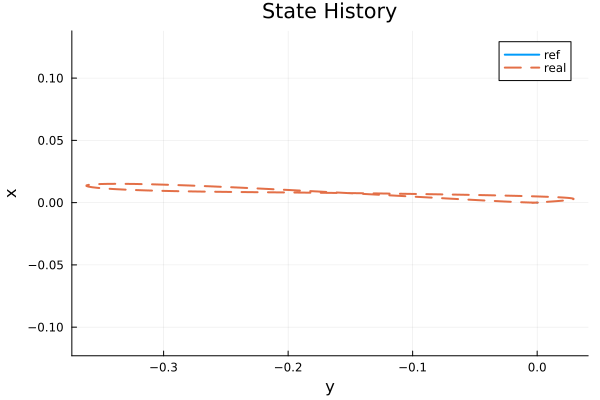

In [289]:
Xsim_m = mat_from_vec(Xref[1:Nsim])
plot(Xsim_m[2,:],Xsim_m[1,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="y", ylabel="x")
Xsim_m = mat_from_vec(xhist[1:Nsim])   
display(plot!(Xsim_m[2,:],Xsim_m[1,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="y", ylabel="x", aspect_ratio=:equal))

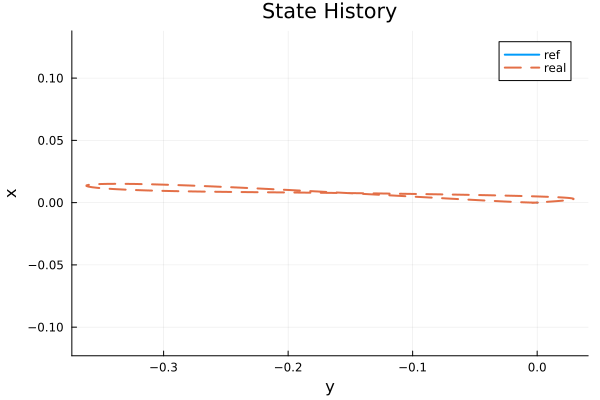

In [290]:
Xsim_m = mat_from_vec(Xref[1:1:Nsim])
plot(Xsim_m[2,:],Xsim_m[1,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="y", ylabel="x")
Xsim_m = mat_from_vec(xhist[1:1:Nsim])   
display(plot!(Xsim_m[2,:],Xsim_m[1,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="y", ylabel="x", aspect_ratio=:equal))

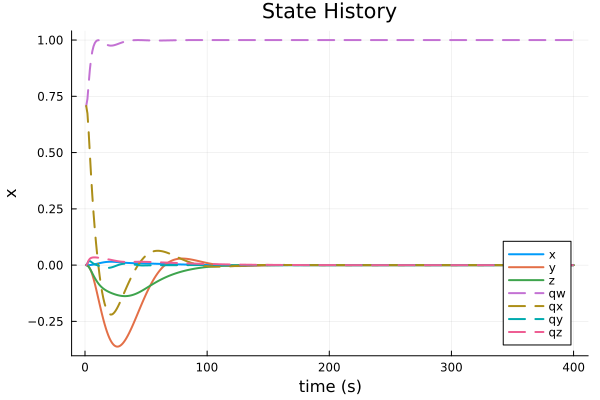

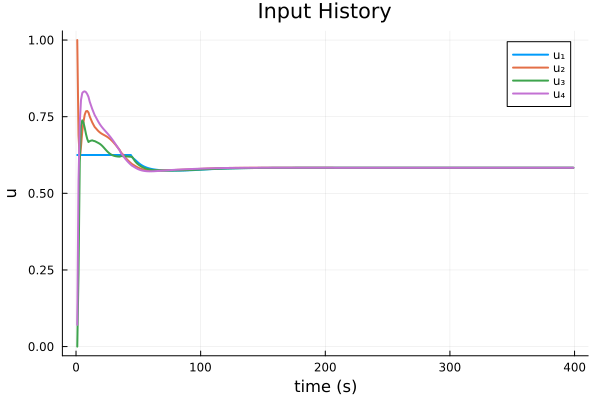

35.29244853561564

In [291]:
Xsim_m = mat_from_vec(xhist[1:Nsim]-0*Xref[1:Nsim])   
Usim_m = mat_from_vec(uhist[1:Nsim-1])   
display(plot(Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))
norm(xhist[1:Nsim]-0*Xref[1:Nsim])

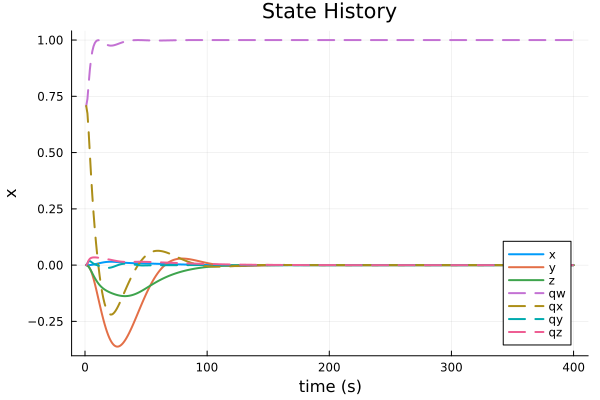

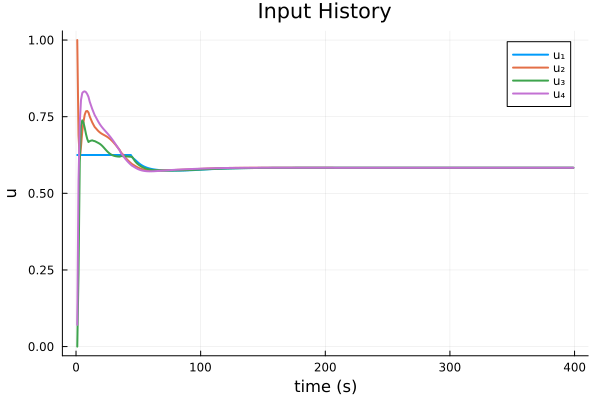

35.29244853561564

In [292]:
Xsim_m = mat_from_vec(xhist[1:Nsim])   
Usim_m = mat_from_vec(uhist[1:Nsim-1])   
display(plot(Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))
norm(xhist[1:Nsim]-0*Xref[1:Nsim])            

In [293]:
# function export_mat_to_eigen(prefix, data)
#   str = prefix * "\n"
#   for i = 1:size(data, 1)
#       for j = 1:size(data, 2)
#           this_str = @sprintf("%.6f", data[i, j])
#           str = str * this_str * "f"
#           if (i == size(data, 1) && j == size(data, 2))
#             str = str * ").finished();"
#           else
#             str = str * ","
#           end
#       end
#       str = str * "\n"
#   end
#   str = str * "\n"
#   return str
# end

function export_mat_to_eigen(prefix, data)
  str = prefix * "\n"
  for i = 1:size(data, 1)
      for j = 1:size(data, 2)
          this_str = @sprintf("%.6f", data[i, j])
          str = str * this_str * "f"
          if (i == size(data, 1) && j == size(data, 2))
            str = str * ";"
          else
            str = str * ","
          end
      end
      str = str * "\n"
  end
  str = str * "\n"
  return str
end

open("params_dt"*".h","w") do io
  @printf(io, "%s",export_mat_to_eigen("Kinf << ", cache.Kinf))
  @printf(io, "%s",export_mat_to_eigen("Pinf << ", cache.Pinf))
  @printf(io, "%s",export_mat_to_eigen("A << ", Ã))
  @printf(io, "%s",export_mat_to_eigen("B << ", B̃))
  @printf(io, "%s",export_mat_to_eigen("Quu_inv << ", cache.Quu_inv))
  @printf(io, "%s",export_mat_to_eigen("AmBKt << ",   cache.AmBKt))
  @printf(io, "%s",export_mat_to_eigen("coeff_d2p << ", cache.coeff_d2p))

  # @printf(io, "%s",export_mat_to_eigen("Kinf_s << ", cache.Kinf2))
  # @printf(io, "%s",export_mat_to_eigen("Pinf_s << ", cache.Pinf2))
  # @printf(io, "%s",export_mat_to_eigen("A_s << ", Ãs))
  # @printf(io, "%s",export_mat_to_eigen("B_s << ", B̃s))
  # @printf(io, "%s",export_mat_to_eigen("Quu_inv_s << ", cache.Quu_inv2))
  # @printf(io, "%s",export_mat_to_eigen("AmBKt_s << ",   cache.AmBKt2))
  # @printf(io, "%s",export_mat_to_eigen("coeff_d2p_s << ", cache.coeff_d2p2))
  
  @printf(io, "%s",export_mat_to_eigen("Q << ", Q))
  @printf(io, "%s",export_mat_to_eigen("R << ", R))
end

In [294]:
X_ref_data = [Δx̃ref[i][1:12] for i = 1:Nt]
# Export a vector of Eigen matrix to C header and source 
function export_vec_to_c(filename, var_type, var_name, data)
  declare = "static Eigen::" * var_type * " " * var_name
  def = declare * " = {\n"
  for i=1:length(data)
      def = def * "(Eigen::" * var_type * "() << "
      for j=1:length(data[1])
          def = def * string(data[i][j])
          if j < length(data[1]) 
              def = def * ","
          end
      end
    def = def * ").finished(),\n"
  end
  def = def*"}"

  open(filename*".h","a") do io
          println(io, def * ";\n")
  end
  return true
end
export_vec_to_c("data", "VectorNf", "XrefAll[]", X_ref_data)

true